# Adaptive State Transition

We will be using Burgers' Equation to show this for PDEs.

In [1]:
import jax
import jax.numpy as jnp

import optax
from flax import linen as nn

import sys
import os

import time

# Add /src to path
path_to_src = os.path.abspath(os.path.join(os.getcwd(), '../../../src'))
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

from KAN import KAN
from PIKAN import *

import numpy as np

import matplotlib.pyplot as plt

### Collocation Points

In [2]:
# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,1]), N)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([0,1]), N)) # (64, 2)
BC1_data = - jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,-1]), np.array([1,-1]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

### Loss Function

In [3]:
def pde_loss(params, collocs, state):
    # Eq. parameter
    v = jnp.array(0.01/jnp.pi, dtype=float)
    
    # Define the model function
    variables = {'params' : params, 'state' : state}
    
    def u(vec_x):
        y, spl = model.apply(variables, vec_x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)  # 1st order derivative of t
    u_x = gradf(u, 1, 1)  # 1st order derivative of x
    u_xx = gradf(u, 1, 2) # 2nd order derivative of x
    
    # Residual
    pde_res = u_t(collocs) + u(collocs)*u_x(collocs) - v*u_xx(collocs)
    
    return pde_res

### Non-smooth Update

In [4]:
# Initialize model
layer_dims = [2, 8, 8, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(jax.random.PRNGKey(0), jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.0005
lr_vals['scales'] = {0 : 1.0}

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3, 2500 : 10}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

In [5]:
num_epochs = 3480

model, variables, losses_non_smooth = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=False, loc_w=None, nesterov=False, 
                                             num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=[], 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Epoch 2500: Performing grid update
Total Time: 69.40998697280884 s
Average time per iteration: 0.0199 s


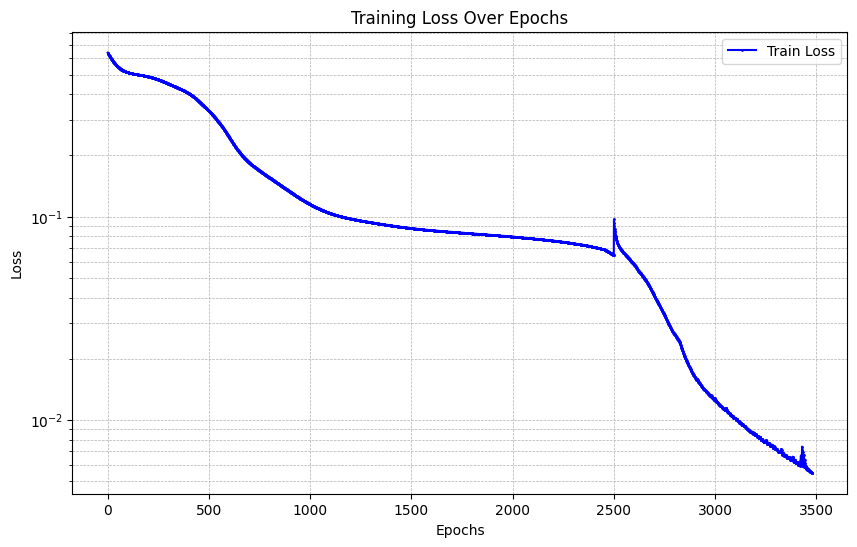

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(losses_non_smooth), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

### Smooth Update

In [7]:
# Initialize model
layer_dims = [2, 8, 8, 1]
model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.05)
variables = model.init(jax.random.PRNGKey(0), jnp.ones([1, 2]))

# Define learning rates for scheduler
lr_vals = dict()
lr_vals['init_lr'] = 0.0005
lr_vals['scales'] = {0 : 1.0, 1500 : 1.0}

# Define epochs for grid adaptation
adapt_every = 276
adapt_stop = 1999
grid_adapt = [i * adapt_every for i in range(1, (adapt_stop // adapt_every) + 1)]
#grid_adapt = [200, 400, 600, 200, 400, 1000, 1500, 1800, 2100, 2700, 3500]

# Define epochs for grid extension, along with grid sizes
grid_extend = {0 : 3, 2500 : 10}

# Define global loss weights
glob_w = [jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float), jnp.array(1.0, dtype=float)]

In [8]:
num_epochs = 3480

model, variables, losses_smooth = train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w=glob_w, 
                                             lr_vals=lr_vals, adapt_state=True, loc_w=None, nesterov=True, 
                                             num_epochs=num_epochs, grid_extend=grid_extend, grid_adapt=grid_adapt, 
                                             colloc_adapt={'epochs' : []})

Epoch 0: Performing grid update
Epoch 2500: Performing grid update
Total Time: 62.49209761619568 s
Average time per iteration: 0.0180 s


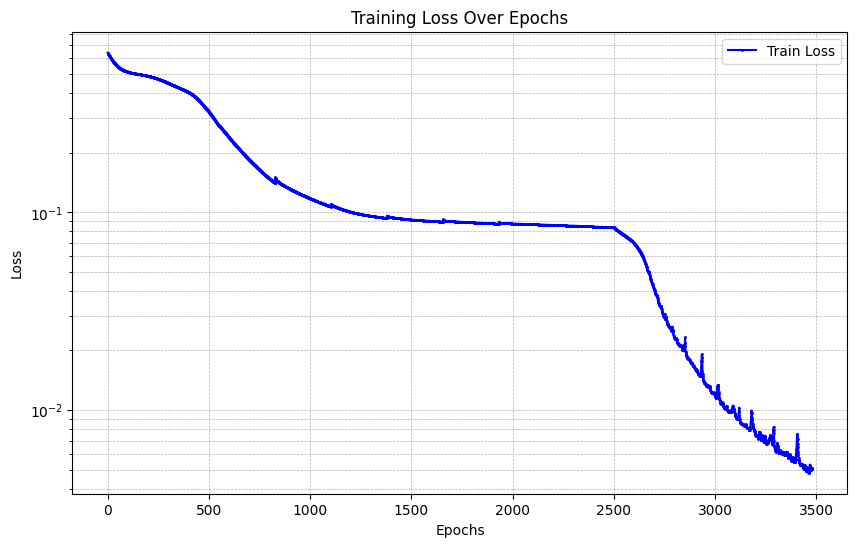

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(losses_smooth), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

### Save Results

In [10]:
epochs = np.arange(num_epochs)
grids = np.array(list(grid_extend.keys()))

In [11]:
np.savez('../Plots/data/state.npz', epochs=epochs, grids=grids, with_a=losses_smooth, without_a=losses_non_smooth)

## Curve Fitting

The effect of the smooth state transition, even without adaptation, is very profound for the problem of curve fitting.

In [7]:
# Use pykan's methods for direct reference
import torch

from kan.utils import create_dataset

f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)

dataset = create_dataset(f, n_var=4, train_num=3000)

X_train = jnp.array(dataset['train_input'].numpy())
X_test = jnp.array(dataset['test_input'].numpy())
y_train = jnp.array(dataset['train_label'].numpy())
y_test = jnp.array(dataset['test_label'].numpy())

In [8]:
# Initialize model
key = jax.random.PRNGKey(0)

layer_dims = [4, 5, 2, 1]

model = KAN(layer_dims=layer_dims, k=3, const_spl=False, const_res=False, add_bias=True, grid_e=0.02)
variables = model.init(key, jnp.ones([10, 4]))

# Define MSE
def loss_fn(params, x, y, state):
    variables = {'params' : params, 'state' : state}
    # Forward pass to acquire predictions and spl_regs
    preds, spl_regs = model.apply(variables, x)

    # Define the prediction loss
    loss_pred = jnp.sqrt(jnp.mean((preds-y)**2))
    
    return loss_pred

@jax.jit
def train_step(params, opt_state, x, y, state):
    
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y, state)
    
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    new_variables = {'params': params, 'state': state}
    
    return new_variables, opt_state, loss

## Non-smooth

In [9]:
# Initialize optimizer
boundaries = [0, 200, 400, 600] # Epochs at which to change the grid & learning rate
grid_vals = [3, 6, 10, 24] # Grid sizes to use
# Corresponding dict
grid_upds = dict(zip(boundaries, grid_vals))

init_lr = 0.02
optimizer = optax.adam(learning_rate=init_lr, nesterov=False)
opt_state = optimizer.init(variables['params'])

# Training epochs
num_epochs = 800

loss_non_smooth = []

for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch+1}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        updated_variables = model.apply(variables, X_train, G_new, method=model.update_grids)
        variables = updated_variables.copy()
        # Re-initialize optimizer
        opt_state = optimizer.init(variables['params'])
        
    # Calculate the loss
    params, state = variables['params'], variables['state']
    variables, opt_state, loss = train_step(params, opt_state, X_train, y_train, state)

    loss_non_smooth.append(loss)

Epoch 1: Performing grid update
Epoch 201: Performing grid update
Epoch 401: Performing grid update
Epoch 601: Performing grid update


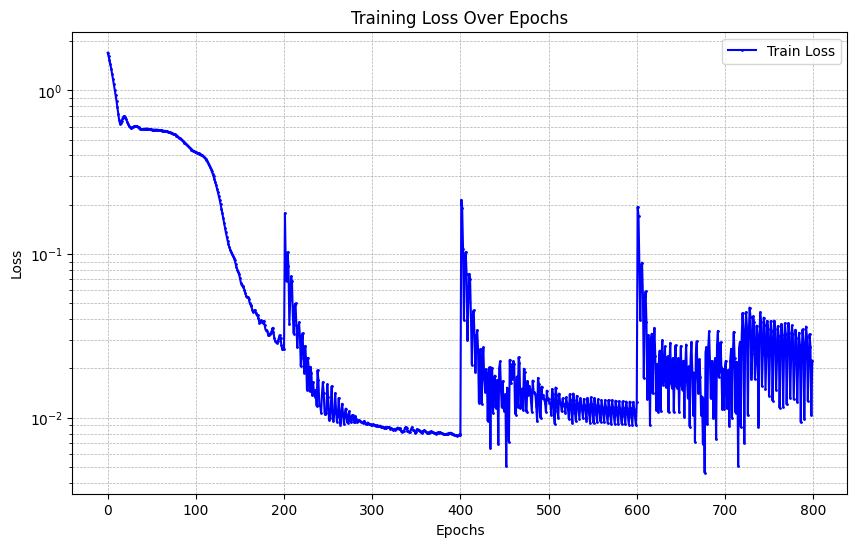

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(loss_non_smooth), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

## Smooth

In [4]:
# Initialize optimizer
boundaries = [0, 200, 400, 600] # Epochs at which to change the grid & learning rate
scales = [1.0, 0.5, 0.2, 0.5] # Learning rate scales
grid_vals = [3, 6, 10, 24] # Grid sizes to use

init_lr = 0.02

# Corresponding dicts
lr_scales = dict(zip(boundaries, scales))
grid_upds = dict(zip(boundaries, grid_vals))

# Create a piecewise constant schedule
schedule = optax.piecewise_constant_schedule(
    init_value=init_lr,
    boundaries_and_scales=lr_scales
)

optimizer = optax.adam(learning_rate=schedule, nesterov=True)

opt_state = optimizer.init(variables['params'])

# Training epochs
num_epochs = 800

loss_smooth = []

for epoch in range(num_epochs):
    # Check if we're in an update epoch
    if epoch in grid_upds.keys():
        print(f"Epoch {epoch+1}: Performing grid update")
        # Get grid size
        G_new = grid_upds[epoch]
        # Perform the update
        updated_variables = model.apply(variables, X_train, G_new, method=model.update_grids)
        variables = updated_variables.copy()
        # Re-initialize optimizer smoothly
        opt_state = state_transition(opt_state, variables)
        
    # Calculate the loss
    params, state = variables['params'], variables['state']
    variables, opt_state, loss = train_step(params, opt_state, X_train, y_train, state)

    loss_smooth.append(loss)

Epoch 1: Performing grid update
Epoch 201: Performing grid update
Epoch 401: Performing grid update
Epoch 601: Performing grid update


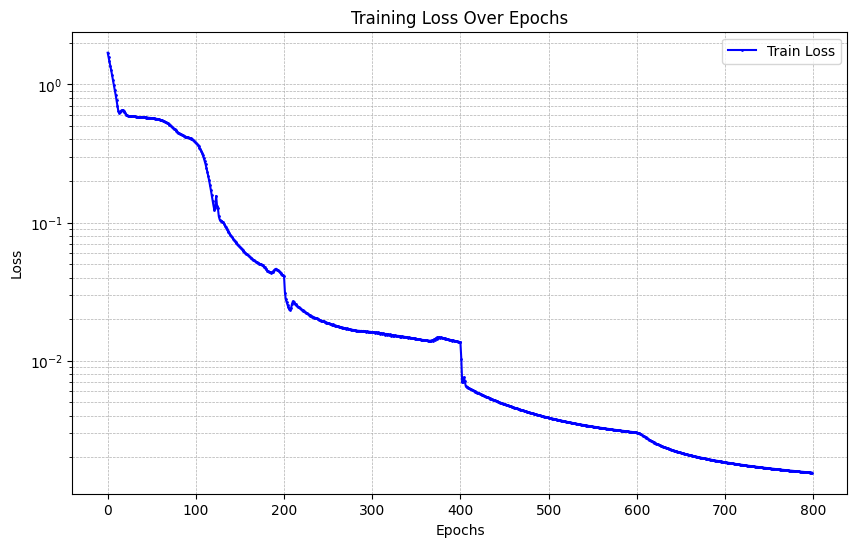

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(loss_smooth), label='Train Loss', marker='o', color='blue', markersize=1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.yscale('log')  # Set y-axis to logarithmic scale

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5) 

plt.show()

### Save Results for Appendix Plot

In [13]:
epochs = np.arange(num_epochs)
grids = np.array(list(grid_upds.keys()))

In [14]:
np.savez('../Plots/data/state_curve.npz', epochs=epochs, grids=grids, with_a=loss_smooth, without_a=loss_non_smooth)